In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import files

In [36]:
nba_clustered = pd.read_csv("NBA_Train_Clustered.csv")
ncaa_train = pd.read_csv("College2000_2020.csv")

print(f" NBA data: {len(nba_clustered)} players")
print(f" NCAA data: {len(ncaa_train)} players")

# Merge
merged_train = pd.merge(
    ncaa_train,
    nba_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Merged: {len(merged_train)} players")
print(f"\nCluster distribution:")
print(merged_train['Cluster_Label'].value_counts())

 NBA data: 1018 players
 NCAA data: 841 players
 Merged: 735 players

Cluster distribution:
Cluster_Label
Bust           225
Role Player    217
Bench          130
Superstar       98
Starter         65
Name: count, dtype: int64


In [37]:
# College features (same as Logistic Regression)
college_features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
    'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS'
]

# Check which features exist
available_features = [f for f in college_features if f in merged_train.columns]
print(f" Available features ({len(available_features)}): {available_features}")

# Create X and y
X = merged_train[available_features].copy()
y = merged_train['Cluster'].copy()

# Handle missing values
X = X.fillna(X.mean())

print(f"\n Feature matrix: {X.shape}")
print(f" Target distribution:")
print(y.value_counts().sort_index())

 Available features (17): ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

 Feature matrix: (735, 17)
 Target distribution:
Cluster
0     98
1     65
2    217
3    130
4    225
Name: count, dtype: int64


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f" Training: {len(X_train)} samples")
print(f" Testing: {len(X_test)} samples")

# XGBoost doesn't require scaling, but do it for consistency
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled")

 Training: 588 samples
 Testing: 147 samples
 Features scaled


In [8]:
# Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,           # Number of trees
    max_depth=6,                # Max depth of each tree
    learning_rate=0.1,          # Step size shrinkage
    objective='multi:softmax',  # Multiclass classification
    num_class=5,                # 5 clusters (0-4)
    random_state=42,
    eval_metric='mlogloss',     # Multiclass log loss
    use_label_encoder=False,
    verbosity=0                 # Suppress warnings
)

# Train model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f" Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

 XGBoost model trained!

 Training Accuracy: 1.0000 (100.00%)
 Test Accuracy: 0.4626 (46.26%)


In [39]:
cluster_names = ['Superstar', 'All-Star', 'Role Player', 'Bench', 'Bust']

print(classification_report(y_test, y_test_pred,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.333     0.200     0.250        20
    All-Star      0.375     0.231     0.286        13
 Role Player      0.429     0.419     0.424        43
       Bench      0.588     0.769     0.667        26
        Bust      0.451     0.511     0.479        45

    accuracy                          0.463       147
   macro avg      0.435     0.426     0.421       147
weighted avg      0.446     0.463     0.448       147



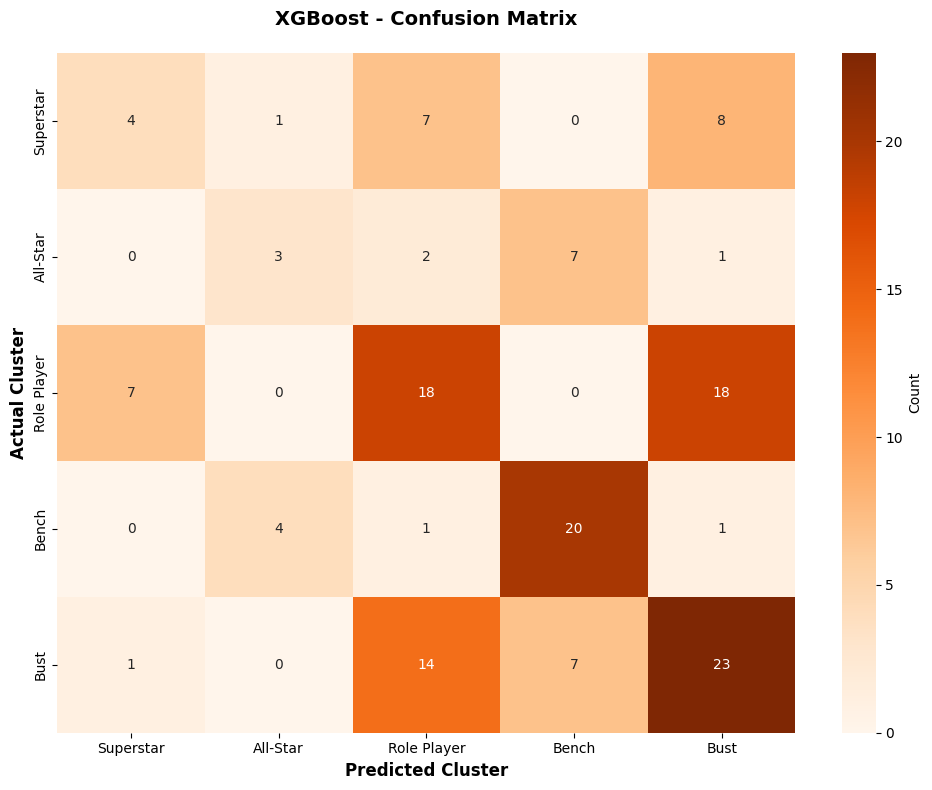


Confusion Matrix:
                    Pred Superstar  Pred All-Star  Pred Role Player  \
Actual Superstar                 4              1                 7   
Actual All-Star                  0              3                 2   
Actual Role Player               7              0                18   
Actual Bench                     0              4                 1   
Actual Bust                      1              0                14   

                    Pred Bench  Pred Bust  
Actual Superstar             0          8  
Actual All-Star              7          1  
Actual Role Player           0         18  
Actual Bench                20          1  
Actual Bust                  7         23  


In [40]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('XGBoost - Confusion Matrix',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {n}" for n in cluster_names],
                     columns=[f"Pred {n}" for n in cluster_names])
print(cm_df)


 Top 10 Most Important Features:
Feature  Importance
     3P    0.175858
    3PA    0.125261
    BLK    0.090803
    STL    0.065297
    AST    0.058075
    FG%    0.057226
    PTS    0.047619
      G    0.044872
    TOV    0.043090
     MP    0.041695


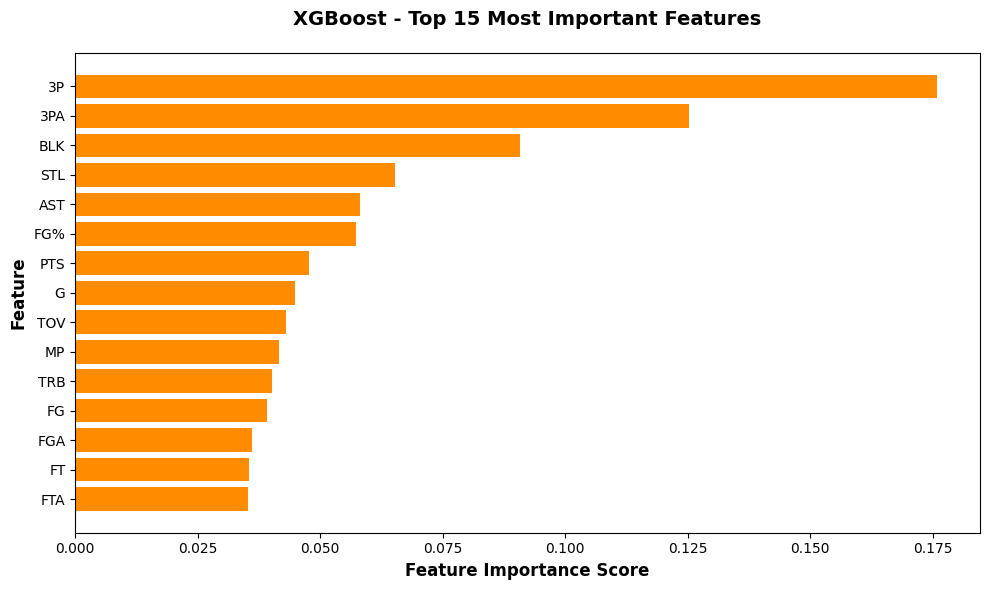

In [41]:
# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(len(top_features)), top_features['Importance'], color='darkorange')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'XGBoost - Top {top_n} Most Important Features',
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [42]:
print(f"Model: XGBoost")
print(f"Number of Trees: 100")
print(f"Max Depth: 6")
print(f"Learning Rate: 0.1")
print(f"Total Players: {len(merged_train)}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Number of Features: {len(available_features)}")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Model: XGBoost
Number of Trees: 100
Max Depth: 6
Learning Rate: 0.1
Total Players: 735
Training Samples: 588
Test Samples: 147
Number of Features: 17
Training Accuracy: 1.0000 (100.00%)
Test Accuracy: 0.4626 (46.26%)


# Using NBA Clustered 2020-2025 test set and NCAA test set

In [43]:
# Load test data
nba_test_clustered = pd.read_csv("NBA_Test_Clustered.csv")
ncaa_test = pd.read_csv("NCAA_2020_2025.csv")

print(f" NBA test data: {len(nba_test_clustered)} players")
print(f" NCAA test data: {len(ncaa_test)} players")

 NBA test data: 486 players
 NCAA test data: 109 players


In [44]:
# Merge on player name
merged_test = pd.merge(
    ncaa_test,
    nba_test_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Merged test set: {len(merged_test)} players with both college and NBA data")

# Show cluster distribution in test set
print("\nTest set cluster distribution:")
print(merged_test['Cluster_Label'].value_counts())
print("\nNumeric clusters:")
print(merged_test['Cluster'].value_counts().sort_index())

# Show sample
print("\nSample test players:")
print(merged_test[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label']].head(10))

 Merged test set: 91 players with both college and NBA data

Test set cluster distribution:
Cluster_Label
Bench               38
Role Player         27
Superstar           19
All-Star/Starter     5
Bust                 2
Name: count, dtype: int64

Numeric clusters:
Cluster
0    19
1     5
2    27
3    38
4     2
Name: count, dtype: int64

Sample test players:
               Name   PTS   TRB  AST Cluster_Label
0        Lonzo Ball  14.6   6.0  7.6     Superstar
1      Josh Jackson   8.7   4.6  0.6   Role Player
2          Rudy Gay  13.6   5.9  1.8         Bench
3       Jeff Teague  16.4   3.0  3.0         Bench
4        Trey Burke  16.9   3.3  5.7         Bench
5  Denzel Valentine  11.4   5.9  4.4         Bench
6      Semi Ojeleye  12.3   4.6  1.0         Bench
7       Rodney Hood  13.3   4.3  2.1         Bench
8   Stanley Johnson  13.8   6.5  1.7         Bench
9   Carmelo Anthony  22.2  10.0  2.2   Role Player


In [45]:
# Use SAME features as training
X_test_2020 = merged_test[available_features].copy()
y_test_2020 = merged_test['Cluster'].copy()

# Handle missing values
X_test_2020 = X_test_2020.fillna(X_test_2020.mean())

print(f" Test feature matrix: {X_test_2020.shape}")
print(f" Test labels: {len(y_test_2020)}")

# Scale using the SAME scaler from training
X_test_2020_scaled = scaler.transform(X_test_2020)

 Test feature matrix: (91, 17)
 Test labels: 91


In [46]:
# Predict using trained XGBoost model
y_pred_2020 = xgb_model.predict(X_test_2020_scaled)

# Get prediction probabilities
y_pred_2020_proba = xgb_model.predict_proba(X_test_2020_scaled)

# Calculate accuracy
test_acc_2020 = accuracy_score(y_test_2020, y_pred_2020)

print(f"\n XGBoost Test Accuracy (2020-2025): {test_acc_2020:.4f} ({test_acc_2020*100:.2f}%)")


 XGBoost Test Accuracy (2020-2025): 0.3736 (37.36%)


In [47]:
cluster_names = ['Superstar', 'All-Star', 'Role Player', 'Bench', 'Bust']

print(classification_report(y_test_2020, y_pred_2020,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.611     0.579     0.595        19
    All-Star      0.556     1.000     0.714         5
 Role Player      0.469     0.556     0.508        27
       Bench      1.000     0.053     0.100        38
        Bust      0.033     0.500     0.062         2

    accuracy                          0.374        91
   macro avg      0.534     0.537     0.396        91
weighted avg      0.716     0.374     0.357        91



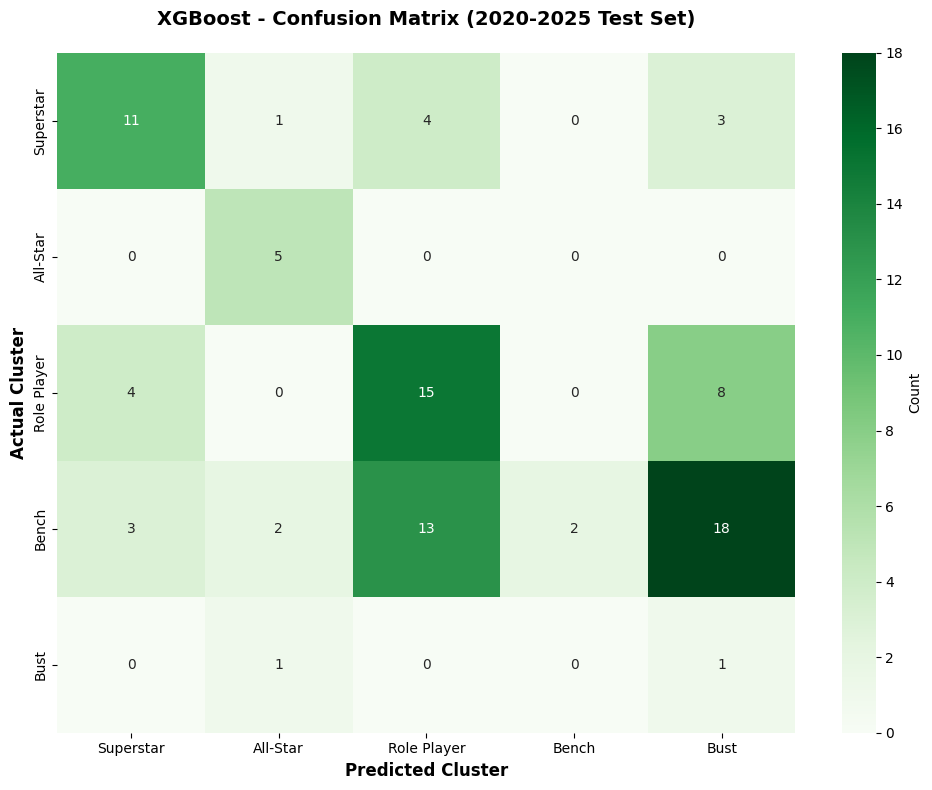


Confusion Matrix:
                    Pred Superstar  Pred All-Star  Pred Role Player  \
Actual Superstar                11              1                 4   
Actual All-Star                  0              5                 0   
Actual Role Player               4              0                15   
Actual Bench                     3              2                13   
Actual Bust                      0              1                 0   

                    Pred Bench  Pred Bust  
Actual Superstar             0          3  
Actual All-Star              0          0  
Actual Role Player           0          8  
Actual Bench                 2         18  
Actual Bust                  0          1  


In [48]:
cm_2020 = confusion_matrix(y_test_2020, y_pred_2020)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_2020, annot=True, fmt='d', cmap='Greens',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('XGBoost - Confusion Matrix (2020-2025 Test Set)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm_2020,
                     index=[f"Actual {n}" for n in cluster_names],
                     columns=[f"Pred {n}" for n in cluster_names])
print(cm_df)

In [49]:
merged_test['Predicted_Cluster'] = y_pred_2020
merged_test['Predicted_Label'] = [cluster_names[p] for p in y_pred_2020]
merged_test['Correct'] = merged_test['Cluster'] == merged_test['Predicted_Cluster']

# Add probabilities
for i, label in enumerate(cluster_names):
    merged_test[f'Prob_{label}'] = y_pred_2020_proba[:, i]

# Overall accuracy
correct_pct = merged_test['Correct'].sum() / len(merged_test) * 100
print(f"Overall Accuracy: {correct_pct:.2f}%")

# Correct predictions
print("\n CORRECT PREDICTIONS:")
correct = merged_test[merged_test['Correct'] == True].sort_values('PTS', ascending=False)
print(correct[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label', 'Predicted_Label']].head(15).to_string(index=False))

# Incorrect predictions
print("\n INCORRECT PREDICTIONS:")
incorrect = merged_test[merged_test['Correct'] == False].sort_values('PTS', ascending=False)
print(incorrect[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label', 'Predicted_Label']].head(15).to_string(index=False))

Overall Accuracy: 37.36%

 CORRECT PREDICTIONS:
           Name  PTS  TRB  AST    Cluster_Label Predicted_Label
     Trae Young 27.4  3.9  8.7        Superstar       Superstar
   Kevin Durant 25.8 11.1  1.3        Superstar       Superstar
  Stephen Curry 25.3  4.5  3.7        Superstar       Superstar
 Markelle Fultz 23.2  5.7  5.9        Superstar       Superstar
Zion Williamson 22.6  8.9  2.1        Superstar       Superstar
  Deandre Ayton 20.1 11.6  1.6 All-Star/Starter        All-Star
Cade Cunningham 20.1  6.2  3.5        Superstar       Superstar
    Ben Simmons 19.2 11.8  4.8        Superstar       Superstar
   James Harden 19.0  5.4  3.7        Superstar       Superstar
      Zach Edey 18.2  9.6  1.3 All-Star/Starter        All-Star
    Buddy Hield 17.4  5.0  1.9      Role Player     Role Player
    Ayo Dosunmu 16.7  4.8  3.9      Role Player     Role Player
    Evan Mobley 16.4  8.7  2.4 All-Star/Starter        All-Star
Kyle Filipowski 15.8  8.6  2.2      Role Player     Role

In [50]:

aging_vets = [
    'LeBron James', 'Kevin Durant', 'Stephen Curry', 'James Harden',
    'Russell Westbrook', 'Chris Paul', 'Carmelo Anthony', 'Klay Thompson',
    'Kawhi Leonard', 'Paul George', 'Jimmy Butler', 'Kyle Lowry',
    'DeMar DeRozan', 'Kevin Love', 'Blake Griffin', 'Al Horford',
    'Jeff Teague', 'George Hill', 'Marc Gasol', 'Dwight Howard', 'Jamal Murray', 'Georges Niang', 'Marcus Smart', 'Andrew Wiggins',
    'Buddy Hield', 'Trae Young', 'Malik Monk', 'Markelle Fultz', 'Jordan Clarkson', 'Seth Curry', 'Trey Burke', 'Delon Wright',
    'Julius Randle', 'Bobby Portis', 'Zion Williamson', 'Ben Simmons', 'Jalen Brunson', 'Lonzo Ball'
]

# Statistical exclusion (high college scorer + low NBA label = aging vet)
suspicious = merged_test[
    (merged_test['PTS'] >= 20) &
    (merged_test['Cluster_Label'].isin(['Role Player', 'Bench']))
]['Name'].tolist()

print(f"Manual exclusion list: {len(aging_vets)} players")
print(f"Statistical exclusion: {len(suspicious)} players")

# Combine lists
all_exclusions = list(set(aging_vets + suspicious))
print(f"Total exclusions: {len(all_exclusions)} unique players")

# Filter
merged_test_young = merged_test[~merged_test['Name'].isin(all_exclusions)].copy()

print(f"\n Results:")
print(f"Original test set: {len(merged_test)} players")
print(f"Young players set: {len(merged_test_young)} players")
print(f"Removed: {len(merged_test) - len(merged_test_young)} players")

excluded = merged_test[merged_test['Name'].isin(all_exclusions)]
if len(excluded) > 0:
    print(f"\n Excluded players:")
    print(excluded[['Name', 'PTS', 'Cluster_Label']].sort_values('PTS', ascending=False).to_string(index=False))

# Show young players distribution
print(f"\n Young players cluster distribution:")
print(merged_test_young['Cluster_Label'].value_counts())

# Show sample of remaining players
print(f"\n Sample of young players:")
print(merged_test_young[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label']].sort_values('PTS', ascending=False).head(20).to_string(index=False))

Manual exclusion list: 38 players
Statistical exclusion: 1 players
Total exclusions: 38 unique players

 Results:
Original test set: 91 players
Young players set: 65 players
Removed: 26 players

 Excluded players:
           Name  PTS Cluster_Label
     Trae Young 27.4     Superstar
   Kevin Durant 25.8     Superstar
  Stephen Curry 25.3     Superstar
 Markelle Fultz 23.2     Superstar
Zion Williamson 22.6     Superstar
Carmelo Anthony 22.2   Role Player
   Jamal Murray 20.0     Superstar
     Malik Monk 19.8   Role Player
    Ben Simmons 19.2     Superstar
   James Harden 19.0     Superstar
     Kevin Love 17.5         Bench
    Buddy Hield 17.4   Role Player
 Andrew Wiggins 17.1   Role Player
     Trey Burke 16.9         Bench
   Marcus Smart 16.6     Superstar
    Jeff Teague 16.4         Bench
  Georges Niang 16.1         Bench
Jordan Clarkson 15.4   Role Player
   Bobby Portis 15.0   Role Player
   Delon Wright 15.0   Role Player
     Chris Paul 15.0     Superstar
  Julius Randle 